# Simulating Phase Precession

Early work in the hippocampus reported the phenomenon of theta phase precession, where hippocampal neuron spikes appear to shift to earlier and earlier phases of consecutive theta cycles as rats traverse the neuron's place field. The phenomenon has been attributed to a mismatch between the interburst interval of neuronal spikes and the period of the theta oscillation ([O'Keefe & Recce, 1993](https://onlinelibrary.wiley.com/doi/epdf/10.1002/hipo.450030307); [Skaggs et al., 1996](https://onlinelibrary.wiley.com/doi/epdf/10.1002/%28SICI%291098-1063%281996%296%3A2%3C149%3A%3AAID-HIPO6%3E3.0.CO%3B2-K); [Maurer et al. 2006](https://onlinelibrary.wiley.com/doi/epdf/10.1002/hipo.20202)). 

We do know, however, that the shape of the hippocampal theta oscillation varies as a function of behavior, and increased running speeds coincide with more asymmetric theta cycles ([Sheremet, Burke, & Maurer, 2016](https://www.jneurosci.org/content/jneuro/36/15/4218.full.pdf)).

In this notebook, I set myself up to ask the question of whether hippocampal theta phase precession, as reported in the existing literature, might be attributable in part to the non-sinusoidality of the theta waveform shape coupled with the sinusoidal assumptions we make with traditional filtering techniques.

In [32]:
%reset 
import math 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns


from process_lfps import butter_bandpass_filter
from scipy import signal
from sim_data_tools import Neuron

sns.set(font_scale=2,style='whitegrid') 
pd.set_option('max_colwidth',100)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


A function to generate pink noise.

In [33]:
def voss(nrows, ncols=16):
    """Generates pink noise using the Voss-McCartney algorithm.

    nrows: number of values to generate
    rcols: number of random sources to add

    returns: NumPy array
    """
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)

    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values


### Simulating hippocampal LFP

Below, I generate three simulated LFP traces by first generating an underlying "clean" periodic trace, and mixing it with pink noise: 

- sawtooth only + pinknoise
- sine only + pinknoise
- mix of sawtooth and sine + pinknoise

In [34]:
timePoints = np.linspace(0, 1, 1000)

sigsaw = -signal.sawtooth(2 * np.pi * 10 * timePoints)
pinknoiseseries = voss(len(sigsaw))

signalsaw = (sigsaw+pinknoiseseries)
signalsaw = signalsaw-np.mean(signalsaw)


sigsin = np.sin(sigsaw*np.pi)
pinknoiseseries = voss(len(sigsin))

signalsin = (sigsin+pinknoiseseries)
signalsin = signalsin-np.mean(signalsin)

sigmix = sigsaw + sigsin
pinknoiseseries = voss(len(sigmix))

signalmix = (sigmix+pinknoiseseries)
signalmix = signalmix-np.mean(signalmix)


Text(0.5, 1.0, 'simulated LFP traces')

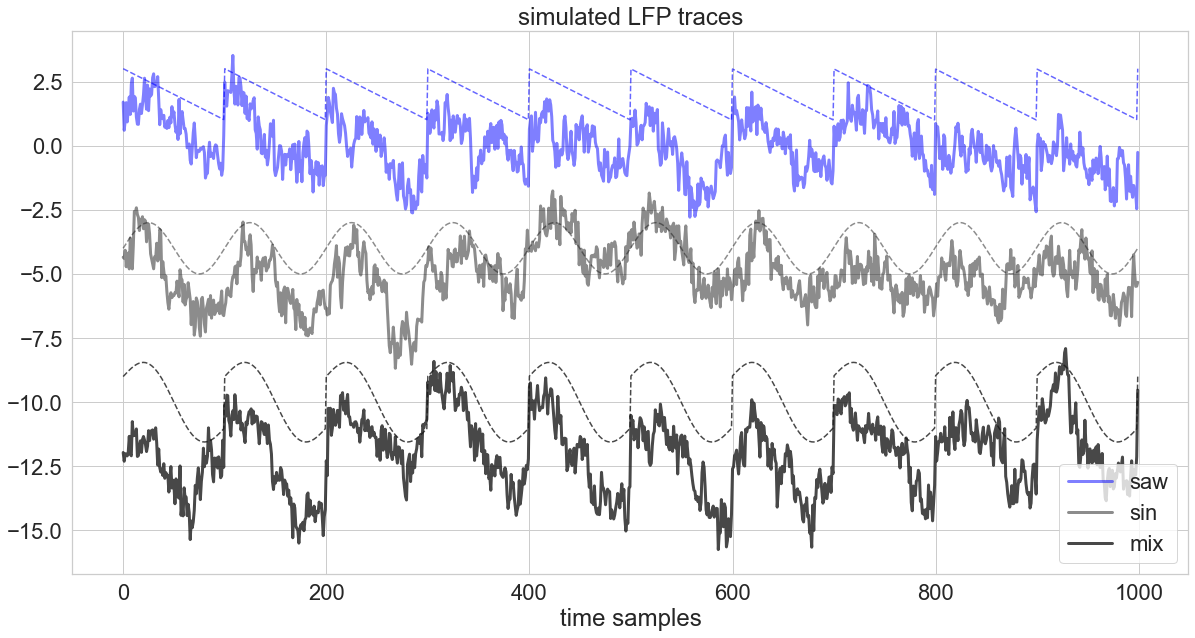

In [35]:
fig,ax=plt.subplots(figsize=(20,10))
ax.plot(signalsaw,color='blue',alpha=0.5, linewidth=3, label = 'saw')
ax.plot(signalsin - 5,color='k',alpha=0.5, linewidth=3, label = 'sin')
ax.plot(signalmix - 12, color = 'k', alpha=0.8, linewidth=3, label = 'mix')


ax.plot(sigsaw + 2,color='blue',alpha=0.6,linestyle="--")
ax.plot(sigsin -4,color='k',alpha=0.5, linestyle="--")
ax.plot(sigmix - 10, color = 'k', alpha=0.8, linestyle="--")



ax.legend()
ax.set_xlabel('time samples')
ax.set_title('simulated LFP traces')

Simulated LFP traces (solid) and their underlying shape timeseries (dotted, vertically offset from their corresponding LFPs). The mix LFP is a little too square to approximate hippocampal run theta -- cycles shouldn't spend quite so much time in the peak, should have a little bit more of a downward slope instead.

### Simulating hippocampal spike train

The original O'Keefe & Recce (1993) found that, at least in a sample cell, the inter burst interval between spikes had a period of ~$11 Hz$, while the modal period of the theta cycles on that same tetrode was a little slower (closer to ~ $9 Hz$). I approximate this mismatch by simulating a spike train with a $12 Hz$ interburst interval, and a simulated LFP oscillating at $10 Hz$.

In [36]:
avg_frate = 25
n_trials = 1
has_rhythm = 1
has_refractory = 1
freq_seq = [12,12]
mu = [0, 0]
kappa = [5,5]
fs = 1000
len_trial = len(timePoints)

pyr = Neuron(avg_frate,
             n_trials,
             has_rhythm,
             has_refractory,
             freq_seq,
             mu,
             kappa,
             fs,
             len_trial
            )

pyr.make_singletrial_phase()
pyr.make_multitrial_phase()
pyr.make_spike_probs()
df = pyr.label_trials()

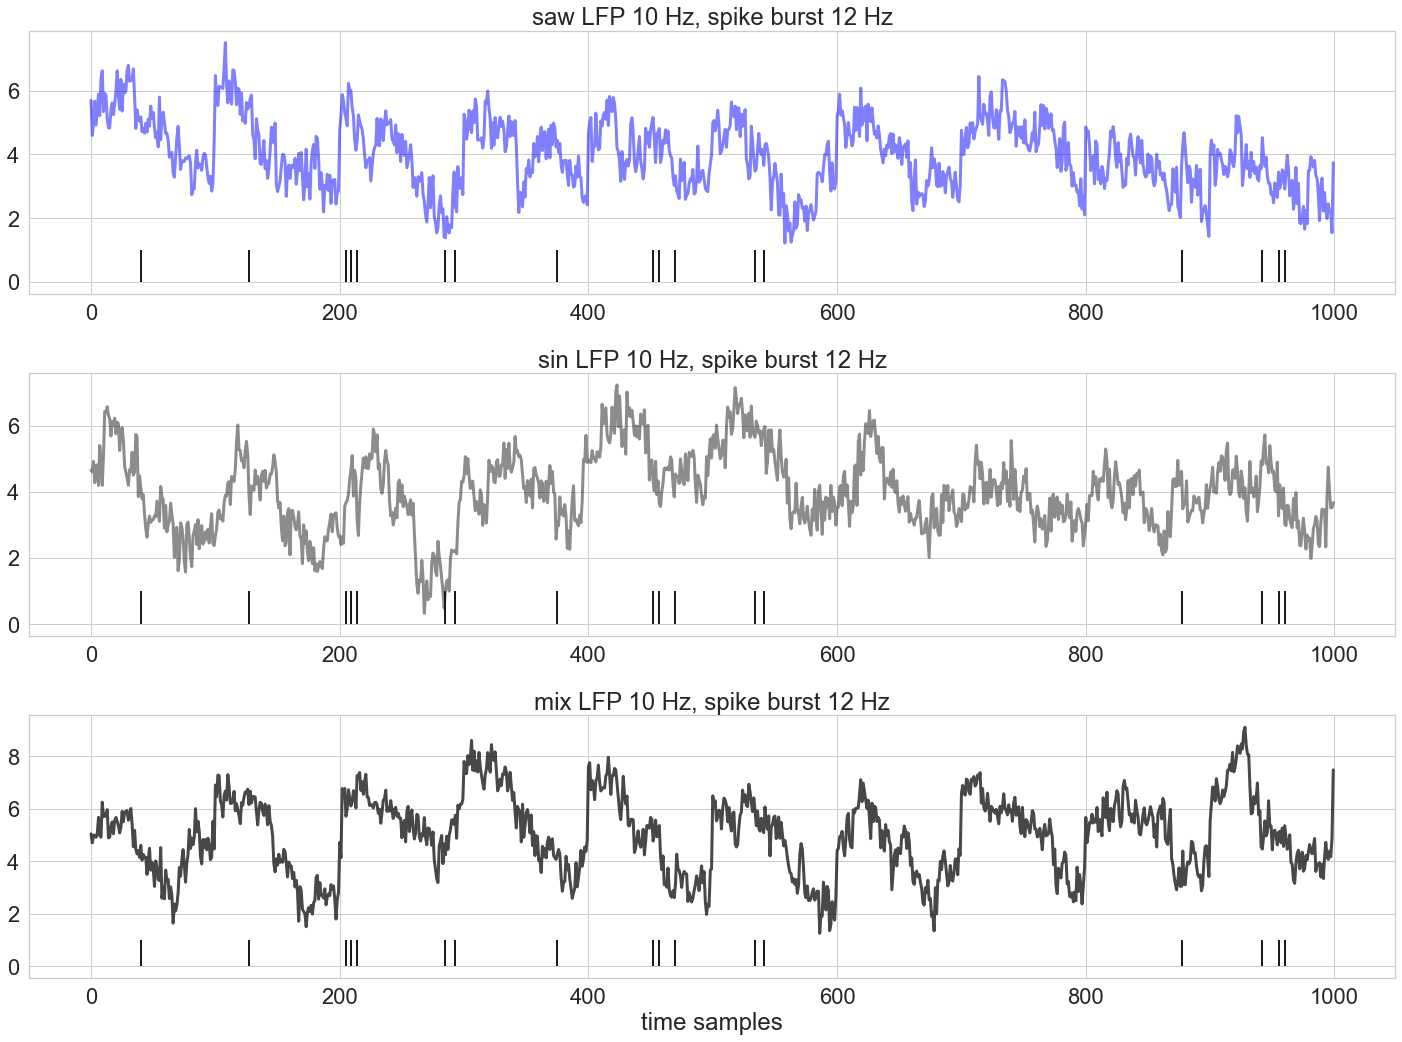

In [37]:
fig,ax=plt.subplots(3,1,figsize=(20,15))

ax[0].plot(signalsaw + 4 , color = 'blue', alpha=0.5, linewidth=3, label = 'saw')
ax[0].vlines(x = df['spikes'].index, ymin = 0, ymax = df['spikes'].values,color='k',linewidth=2)
ax[0].set_title('saw LFP 10 Hz, spike burst 12 Hz')

ax[1].plot(signalsin + 4 , color = 'k', alpha=0.5, linewidth=3, label = 'sin')
ax[1].vlines(x = df['spikes'].index, ymin = 0, ymax = df['spikes'].values,color='k',linewidth=2)
ax[1].set_title('sin LFP 10 Hz, spike burst 12 Hz')

ax[2].plot(signalmix + 5 , color = 'k', alpha=0.8, linewidth=3)
ax[2].vlines(x = df['spikes'].index, ymin = 0, ymax = df['spikes'].values,color='k',linewidth=2)
ax[2].set_title('mix LFP 10 Hz, spike burst 12 Hz')

ax[2].set_xlabel('time samples')

fig.tight_layout()

Here, we can see phase precession by eye, with consecutive cycles coinciding with earlier phases of the corresponding oscillatin. Notably, we can see the phenomenon in all traces!

### Quantify phase precession relative to each LFP 

To quantify the visual intuition, I'll need to compute the estimated phase at each spike in the simulated spike train, for each trace. 

To do this, I'll first bandpass filter the signal between $5$ and $10 Hz$ using a $3rd order$ Butterworth filter, and then compute instantaneous phase estimates using the Hilbert transform. 

In [38]:
filtsaw, phasesaw, ampsaw, _ = butter_bandpass_filter(signalsaw,5,10,1000)
filtsin, phasesin, ampsin, _ = butter_bandpass_filter(signalsin,5,10,1000)
filtmix, phasemix, ampmix, _ = butter_bandpass_filter(signalmix,5,10,1000)

Text(0.5, 1.0, 'band pass filtered signals')

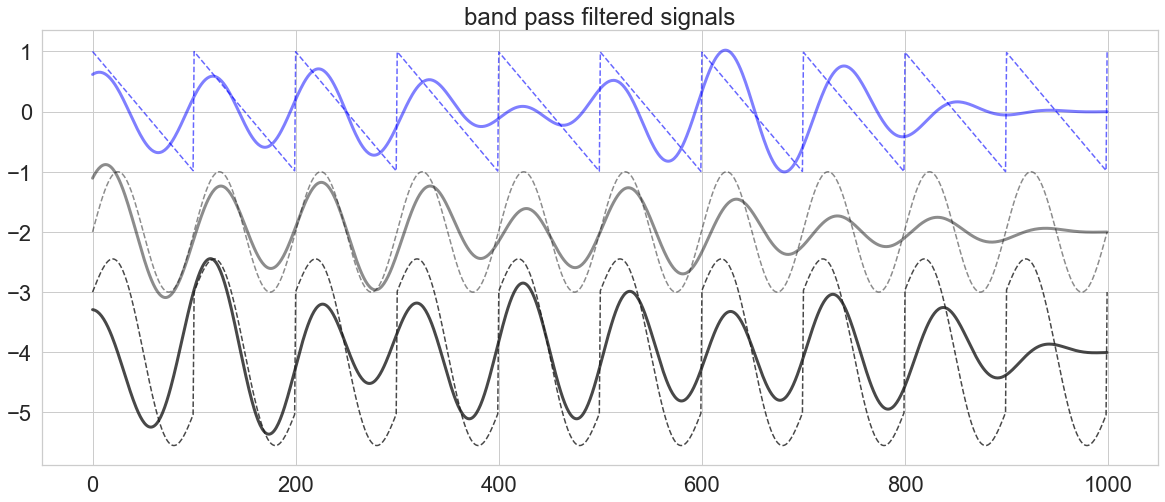

In [39]:
fig,ax=plt.subplots(figsize=(20,8))

ax.plot(filtsaw,color='blue',alpha=0.5,label='saw',linewidth=3)
ax.plot(filtsin - 2,color='k',alpha=0.5,label='sin',linewidth=3)
ax.plot(filtmix - 4,color='k',alpha=0.8,label='mix',linewidth=3)

ax.plot(sigsaw,color='blue',alpha=0.6,linestyle="--")
ax.plot(sigsin -2,color='k',alpha=0.5, linestyle="--")
ax.plot(sigmix - 4, color = 'k', alpha=0.8, linestyle="--")

ax.set_title('band pass filtered signals')

Here, I'm visually comparing the filtered signals (solid trace) for each trace against the corresponding true underlying shape (dotted trace). 

Text(0.5, 1.0, 'bandpass filtered signals')

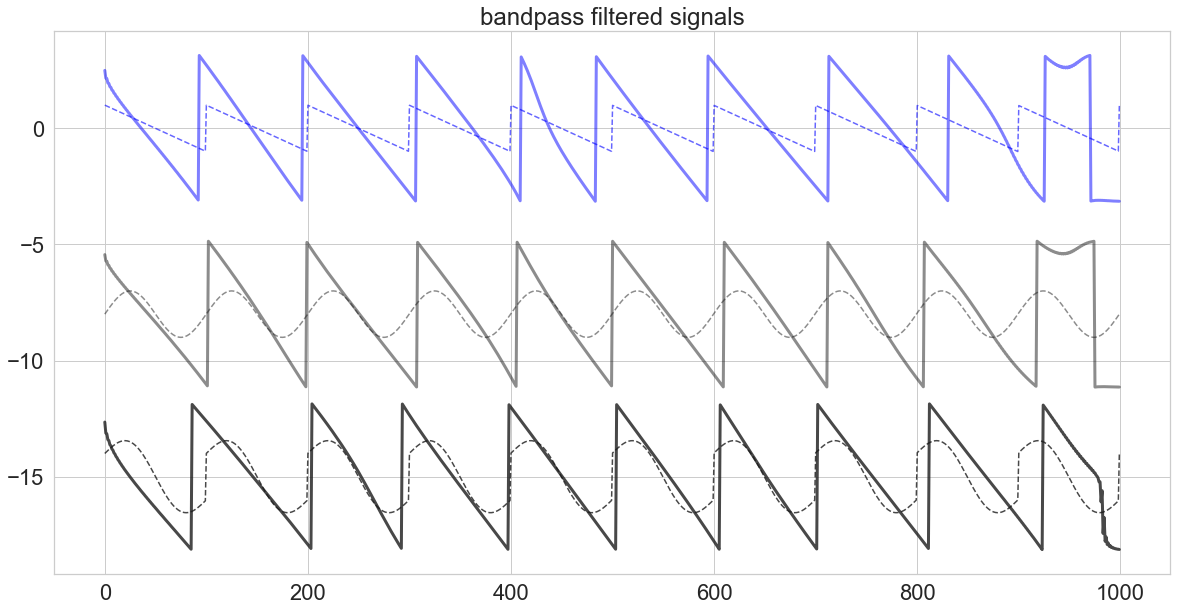

In [40]:
fig,ax=plt.subplots(figsize=(20,10))

ax.plot(phasesaw,color='blue',alpha=0.5,label='saw',linewidth=3)
ax.plot(phasesin - 8,color='k',alpha=0.5,label='sin',linewidth=3)
ax.plot(phasemix - 15,color='k',alpha=0.8,label='mix',linewidth=3)

ax.plot(sigsaw,color='blue',alpha=0.6,linestyle="--")
ax.plot(sigsin -8,color='k',alpha=0.5, linestyle="--")
ax.plot(sigmix - 15, color = 'k', alpha=0.8, linestyle="--")

ax.set_title('bandpass filtered signals')

In [41]:
df['phase_sawLFP'] = phasesaw
df['phase_sinLFP'] = phasesin
df['phase_mixLFP'] = phasemix

degsaw = [math.degrees(phi) for phi in (phasesaw+np.pi)]
degsin = [math.degrees(phi) for phi in (phasesin+np.pi)]
degmix = [math.degrees(phi) for phi in (phasemix+np.pi)]

df['phasedeg_sawLFP'] = degsaw
df['phasedeg_sinLFP'] = degsin
df['phasedeg_mixLFP'] = degmix

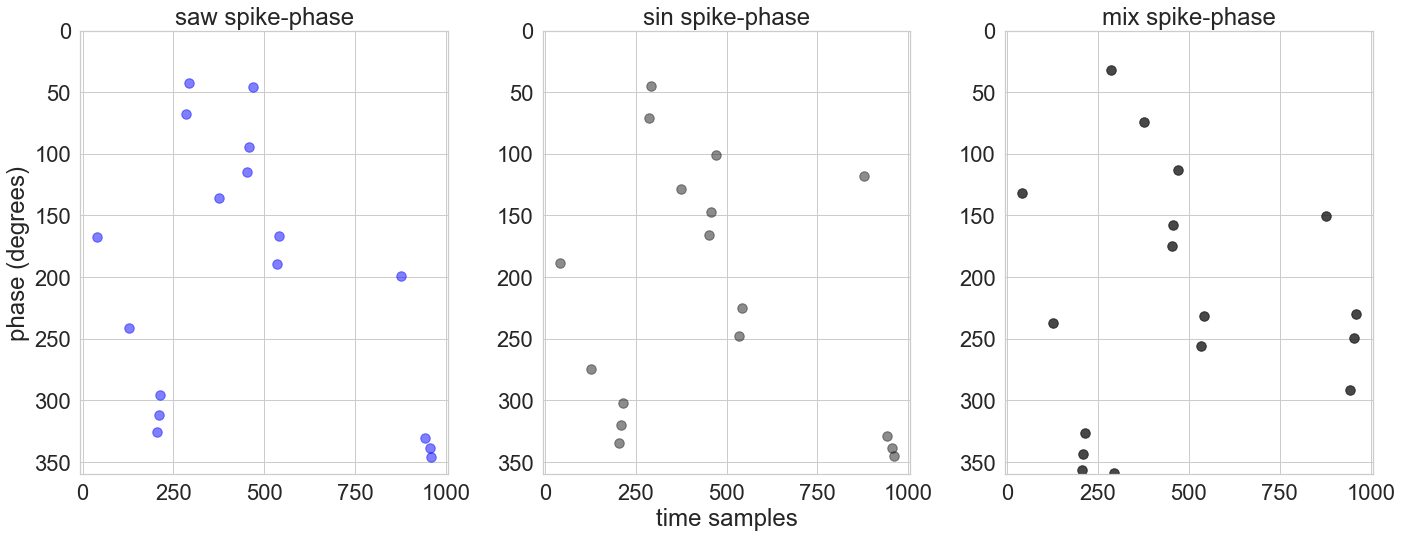

In [42]:
spikes_df = df[df['spikes']==1]

fig,ax=plt.subplots(1,3,figsize=(20,8))


ax[0].scatter(spikes_df.index,spikes_df['phasedeg_sawLFP'],color='blue',alpha=0.5,s=90)
ax[0].set_title('saw spike-phase')
ax[0].set_ylim(360,0)

ax[1].scatter(spikes_df.index,spikes_df['phasedeg_sinLFP'],color='k',alpha=0.5,s=90)
ax[1].set_title('sin spike-phase')
ax[1].set_ylim(360,0)


ax[2].scatter(spikes_df.index,spikes_df['phasedeg_mixLFP'],color='k',alpha=0.8,s=90)
ax[2].set_title('mix spike-phase')
ax[2].set_ylim(360,0)


# ax[0].scatter(spikes_df.index,spikes_df['phase_sawLFP'],color='blue',alpha=0.5,s=90)
# ax[1].scatter(spikes_df.index,spikes_df['phase_sinLFP'],color='k',alpha=0.5,s=90)
# ax[2].scatter(spikes_df.index,spikes_df['phase_mixLFP'],color='k',alpha=0.8,s=90)

ax[0].set_ylabel('phase (degrees)')
ax[1].set_xlabel('time samples')


fig.tight_layout()


I'm not sure if my y axis is right (it seems to coincide with the inverted version of Fig. 4 in [Maurer & McNaughton (2007)](https://reader.elsevier.com/reader/sd/pii/S0166223607001063?token=CA2AEBEEFF2CD1F6BAB6649A58C791BB86726C7D6445A34D68F661BC86DEE70AEC5CD85A4C7E15C5C9CD57C6207CD76E&originRegion=us-east-1&originCreation=20220512203237) but looks like the opposite trend relative to Fig. 7 in [Skaggs et al. 1996](https://onlinelibrary.wiley.com/doi/epdf/10.1002/%28SICI%291098-1063%281996%296%3A2%3C149%3A%3AAID-HIPO6%3E3.0.CO%3B2-K) and Fig. 3 [O'Keefe & Recce (1993)](https://onlinelibrary.wiley.com/doi/epdf/10.1002/hipo.450030307). The flipped y axes might be due to the way I'm computing instantaneous phase estimates? I'm using the Hilbert transform, which gives me phase values that range in time from $-\pi$ to $\pi$, rather than $\pi$ to $-\pi$.

Regardless, it does seem like you can see phase precession for all three signals, regardless of the underlying shape of the LFP. (Although, I noticed when I ran the code a couple of times that, depending on how the pink noise adds onto the sawtooth trace, phase precession is visible or very very _weak_ in the sawtooth LFP). Now, the question is, if we filtered the saw-tooth-shaped LFP in a way that was more true to its shape (rather than assuming it should be filterable with a sinusoidal basis), would we stop seeing phase precession? My hunch is that we probably would, since the precession seems to largely be a function of the mismatch between the period of the oscillation and the period of spike bursts.
